# pythia-degree

Compare Pythia prefetchers against:
- Different fixed degrees (+ dynamic degrees)
- Different fixed degree (+ dynamic degree) baseline prefetchers

TODO: Write notebook

In [2]:
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import plots, tables, utils
%matplotlib widget

In [3]:
# Knobs
fixed_degree_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r_features_degree_fixed.csv' # Degrees 1 .. 8
dynamic_degree_path = '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r_features_degree_dynamic.csv' # Dynamic degree

seed = 1337
suites = {
    'SPEC 06': utils.spec06,
    #'SPEC 17': utils.spec17,
    #'GAP': utils.gap,
}
metrics  = [
    'ipc_improvement', 
    'L2C_issued_prefetches', 
    'L2C_accuracy', 
    'L2C_coverage',
    'pythia_avg_degree',
    #'L2C_mpki_reduction', 
]
features = [
    {'Delta_Path', 'PC_Delta'},  # Analogous to SPP+Bingo
    {'PC_Delta'},  # Analogous to SPP
    {'Delta_Path'},  # Analogous to Bingo
]
baselines = [
    'spp',
    'bingo',
    'bo',
    'bo_orig'
]

# Plots (single benchmarks)
Plot the impact on static degree + dynamic degree for Pythia, vs. Bingo, SPP, and BOP.

In [4]:
fixed_degree_pythia_df = tables.load_stats_csv_pythia(fixed_degree_path, 
                                                      features)
fixed_degree_baseline_df = tables.load_stats_csv(fixed_degree_path, baselines)

dynamic_degree_pythia_df = tables.load_stats_csv_pythia(dynamic_degree_path, 
                                                        features)
dynamic_degree_baseline_df = tables.load_stats_csv(dynamic_degree_path, baselines)

In [5]:
def plot_degree_sweep(fixed_df: dict, dynamic_df: dict, 
                      benchmark: str, metric: str,
                      degrees: List[int] = list(range(1, 9)),
                      figsize: Tuple[int, int] = None,
                      dpi: int = None):
    """TODO: docstring
    """
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    largest_y = 0

    for key in fixed_df.keys():
        # Add an extra spot for dynamic degree
        X = np.arange(len(degrees) + 1)
        y = np.zeros(len(degrees) + 1)

        # Add fixed degrees
        for i, deg in enumerate(degrees):
            y[i] = (fixed_df[key]
                            [((fixed_df[key].trace == benchmark)
                             & (fixed_df[key].L2C_pref_degree == f'({deg},)'))]
                            [metric].mean())
        # Add dynamic degree
        y[-1] = (dynamic_df[key]
                           [dynamic_df[key].trace == benchmark]
                           [metric].mean())
        
        largest_y = max(largest_y, max(y))
        ax.plot(X, y, '.-', label=key)

    # Set ticks based on metric
    if any(s in metric for s in ['ipc_improvement', 'accuracy', 'coverage', 'mpki_reduction']):
        #largest_y = 150
        ax.set_yticks(np.arange(0, round(largest_y, -1) + 10, 10))
    ax.set_xticks(X)
    ax.set_xticklabels(list(map(str, degrees)) + ['dynamic'])
    ax.set_xlabel('Degree')
    ax.set_ylabel(metric)
    
    ax.set_title(f'{benchmark} {metric}')
    ax.grid(axis='y', color='lightgray')
    fig.legend() #bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

def plot_everything_degree(fixed_df: dict, dynamic_df: dict, 
                           benchmarks: List[str],
                           metrics: List[str] = ['ipc_improvement'],
                           degrees: List[int] = list(range(1, 9)),
                           figsize: Tuple[int, int] = (9, 5),
                           dpi: Optional[int] = None):
    """Plot degree graphs for different prefetchers across benchmarks.

    Parameters:
        fixed_df: A dict of prefetchers set to fixed degrees.
        dynamic_df: A dict of prefetchers set to use their dynamic degrees.
        benchmarks: A list of benchmarks.
        metrics: A list of metrics.
        figsize: The matplotlib figsize.
        dpi: The matplotlib DPI.

    Returns: None
    """
    for benchmark in benchmarks:
        for metric in metrics:
            plot_degree_sweep(fixed_df, dynamic_df, 
                              benchmark, metric,
                              degrees=degrees,
                              figsize=figsize, dpi=dpi)
            plt.show()

## libquantum: Pythia vs. SPP

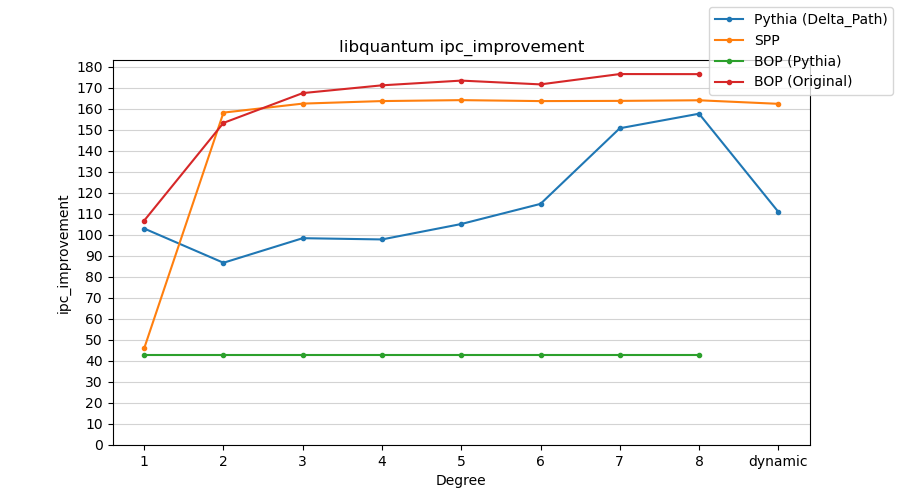

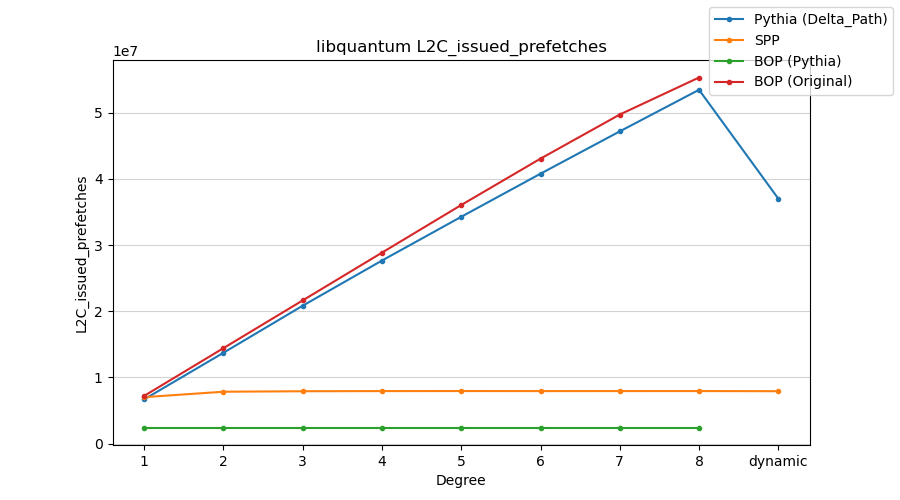

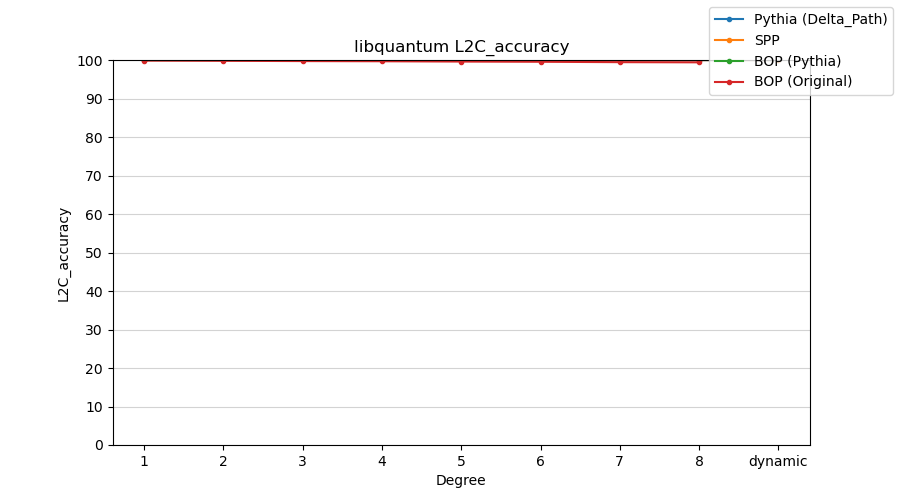

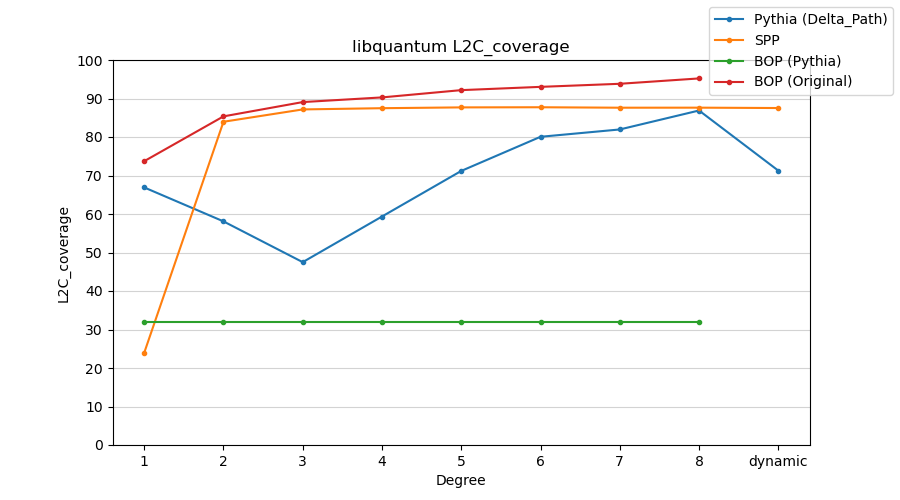

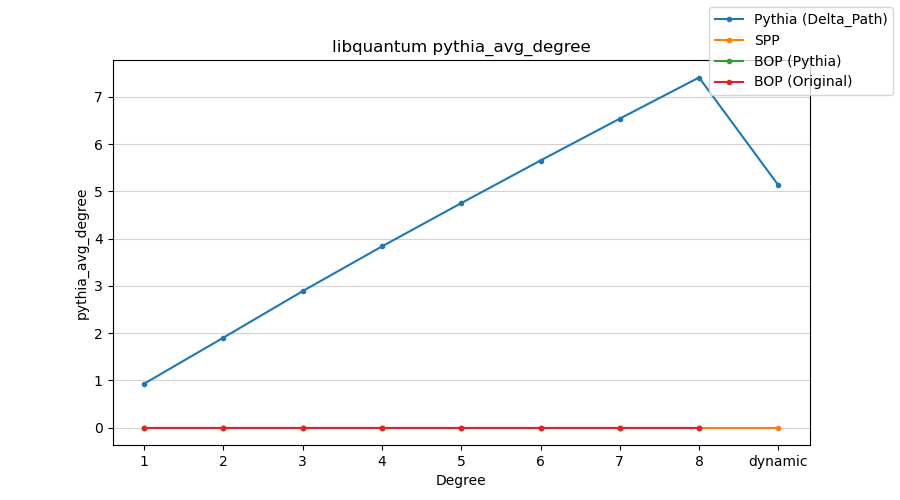

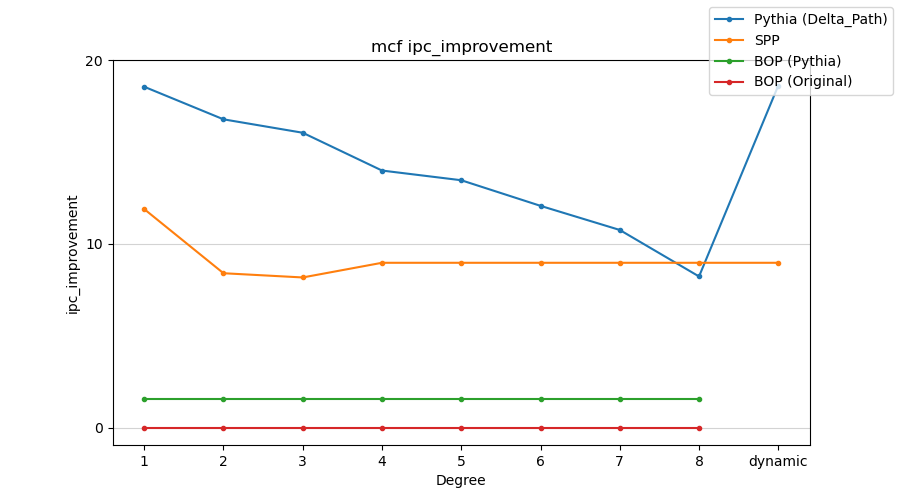

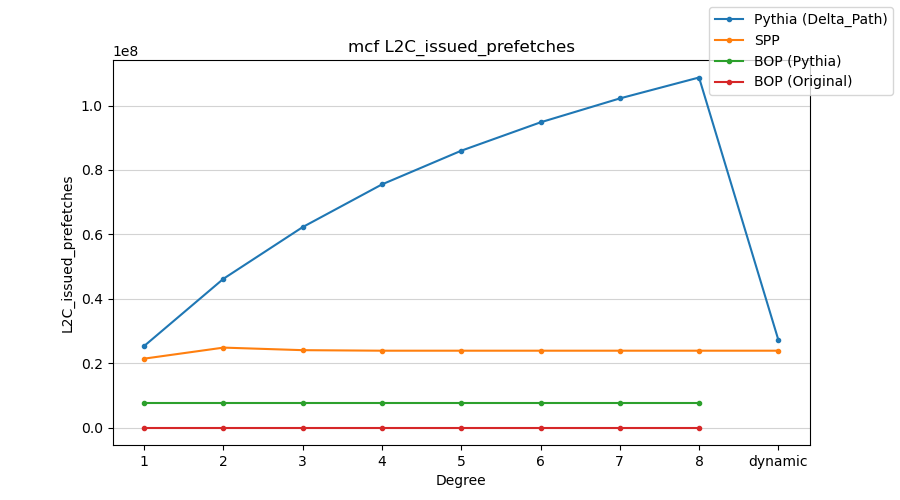

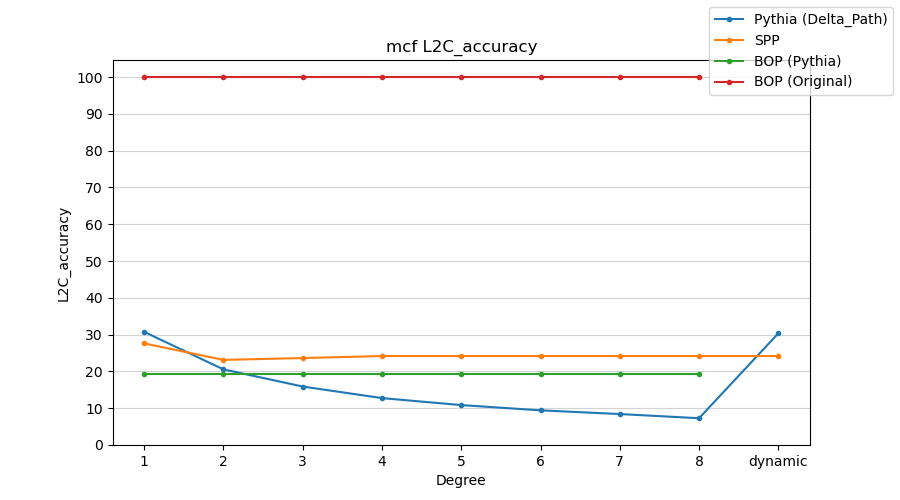

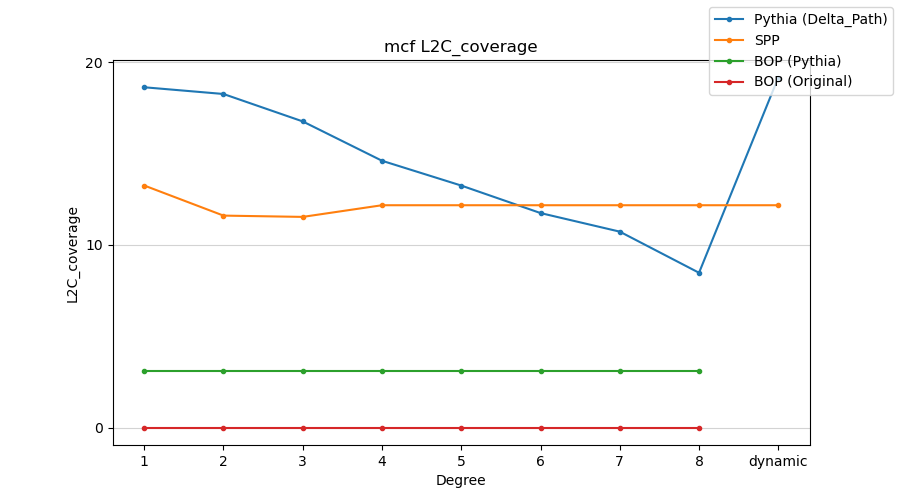

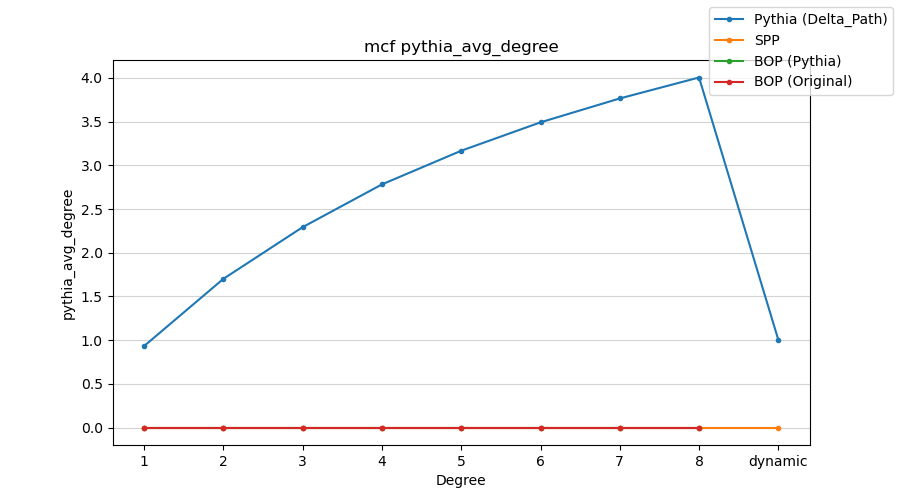

In [6]:
spp_df_fixed = {
    'Pythia (Delta_Path)': fixed_degree_pythia_df['Delta_Path'],
    'SPP': fixed_degree_baseline_df['spp'],
    'BOP (Pythia)': fixed_degree_baseline_df['bo'],
    'BOP (Original)': fixed_degree_baseline_df['bo_orig'],
}
spp_df_dyn = {
    'Pythia (Delta_Path)': dynamic_degree_pythia_df['Delta_Path'],
    'SPP': dynamic_degree_baseline_df['spp'],
    'BOP (Pythia)': dynamic_degree_baseline_df['bo'],
    'BOP (Original)': dynamic_degree_baseline_df['bo_orig'],
}

plot_everything_degree(
    spp_df_fixed, spp_df_dyn, ['libquantum', 'mcf'], metrics)

## libquantum: Pythia vs. Bingo
Note: Bingo has no sense of "degree", so we only see a dot for dynamic degree on Bingo.

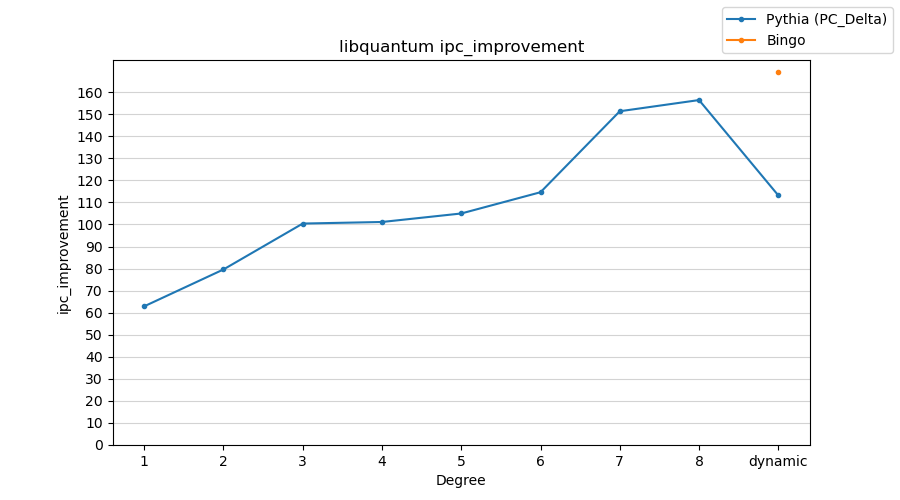

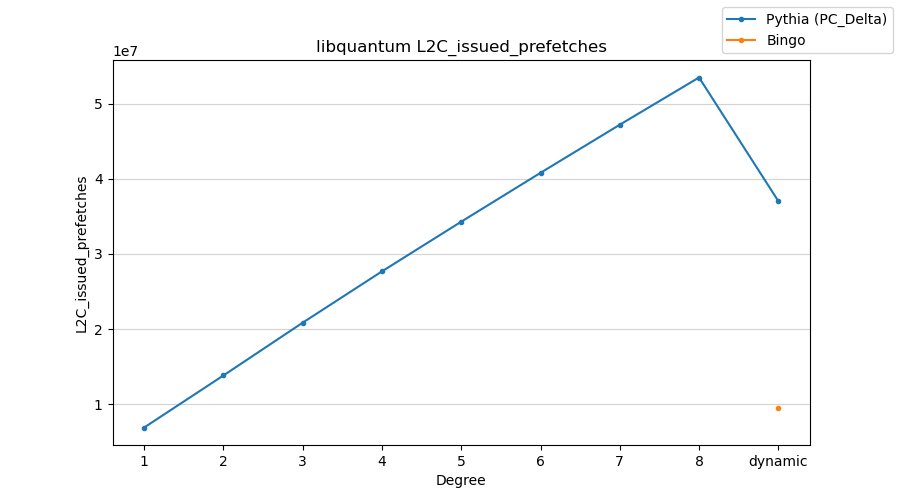

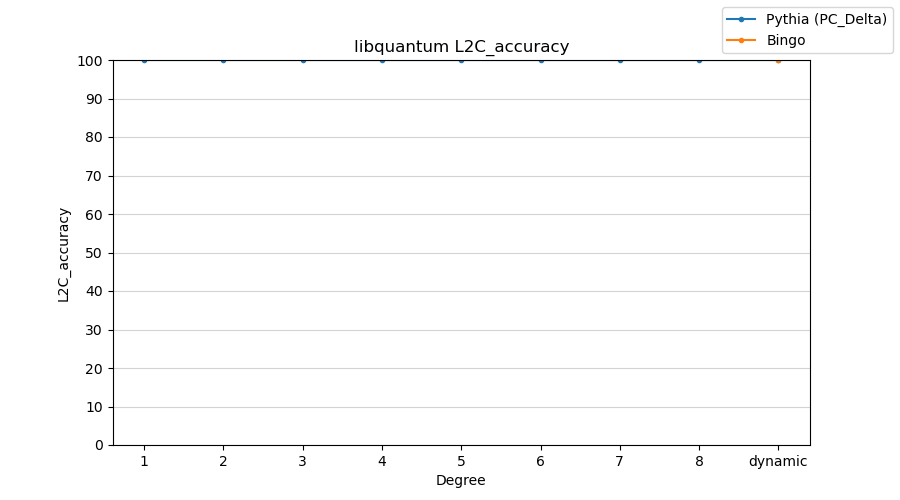

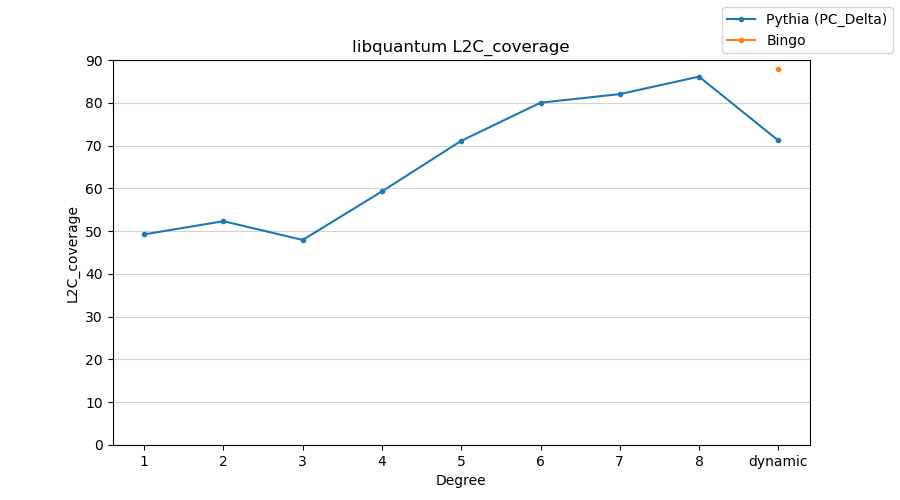

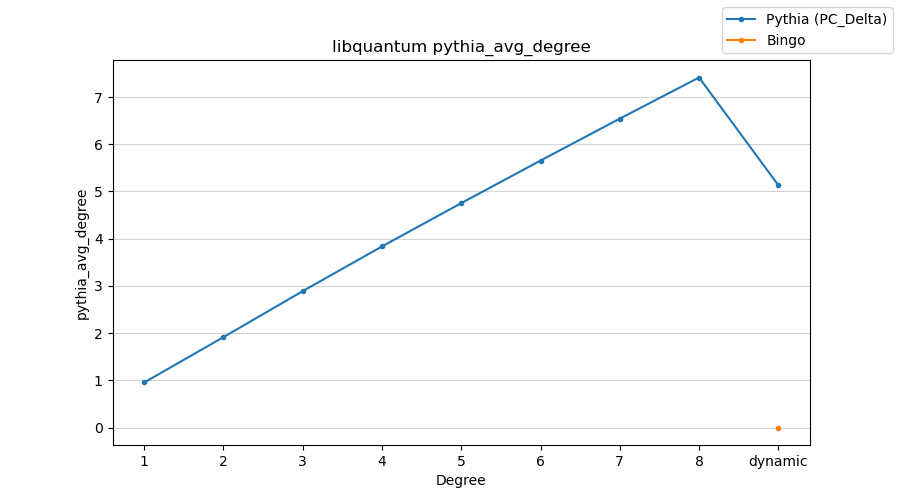

In [13]:
bingo_df_fixed = {
    'Pythia (PC_Delta)': fixed_degree_pythia_df['PC_Delta'],
    'Bingo': fixed_degree_baseline_df['bingo'],
}
bingo_df_dyn = {
    'Pythia (PC_Delta)': dynamic_degree_pythia_df['PC_Delta'],
    'Bingo': dynamic_degree_baseline_df['bingo'],
}

plot_everything_degree(
    bingo_df_fixed, bingo_df_dyn, ['libquantum'], metrics)